Train an embedding given a batch of data collected by a successful run.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import tensorflow as tf
import glob
import math
import skimage

tf.enable_eager_execution()

In [2]:
from IPython.display import clear_output

In [20]:
from softlearning.replay_pools.utils import get_replay_pool_from_variant

def get_grid_vals(env, n_samples):
    n_samples = 50
    obs_space = env.observation_space['state_observation']
    xs = np.linspace(obs_space.low[0], obs_space.high[0], n_samples)
    ys = np.linspace(obs_space.low[1], obs_space.high[1], n_samples)
    xys = np.meshgrid(xs, ys)
    return np.array(xys).transpose(1, 2, 0).reshape((n_samples * n_samples, 2)), xys

def get_replay_pool(checkpoint, checkpoint_dir):
    from softlearning.replay_pools.utils import get_replay_pool_from_variant

    variant = checkpoint['variant']
    train_env = checkpoint['training_environment']
    replay_pool = get_replay_pool_from_variant(variant, train_env)

    replay_pool_path = os.path.join(checkpoint_dir, 'replay_pool.pkl')
    replay_pool.load_experience(replay_pool_path)
    return replay_pool

def plot_trajectories(checkpoint, checkpoint_dir, num_trajectories=10):
    replay_pool = get_replay_pool(checkpoint, checkpoint_dir)
    trajectories = replay_pool.last_n_batch(100 * num_trajectories)['observations']['state_observation'] \
                    .reshape(num_trajectories, 100, -1)
    for i in range(num_trajectories):
        plt.plot(trajectories[i,:,0], trajectories[i,:,1], color='w', linewidth=1)

## Load Run

In [3]:
common_dir = '/Users/kevintli/rail/data/ray_results'
universe = 'gym'
domain = 'Point2D'
task = 'Maze-v0'

In [106]:
base_path = os.path.join(common_dir, universe, domain, task)
exps = sorted(list(glob.iglob(os.path.join(base_path, '*'))))
for i, exp in enumerate(exps):
    print(f'{i} \t {exp.replace(base_path, "")}')
    
exp_choice = int(input('\n Which experiment do you want to analyze? (ENTER A NUMBER) \t'))

exp_path = exps[exp_choice]
print('\n')
seeds = sorted(list(glob.iglob(os.path.join(exp_path, '*'))))
seeds = [seed for seed in seeds if os.path.isdir(seed)]
for i, seed in enumerate(seeds):
    print(f'{i} \t {seed.replace(exp_path, "")}')
    
# TODO: Extend to analyzing all seeds
seed_choice = int(input('\n Which seed do you want to analyze? (ENTER A NUMBER) \t'))

seed_path = seeds[seed_choice]

print('PATH:\n', seed_path)

0 	 /2020-05-27T16-46-37-ddl_maze
1 	 /2020-05-27T18-08-07-ddl_maze_count
2 	 /2020-05-28T15-34-01-dynamics_aware_vice

 Which experiment do you want to analyze? (ENTER A NUMBER) 	1


0 	 /id=b10d1e58-seed=5665_2020-05-27_18-08-08m_k02ani
1 	 /id=b10db96c-seed=2276_2020-05-27_18-08-083tnxtdfm
2 	 /id=b10e2a3c-seed=8785_2020-05-27_18-08-082a4988sb
3 	 /id=b10e9e4a-seed=9604_2020-05-27_18-08-086u1x903v
4 	 /id=b111f374-seed=8761_2020-05-27_18-08-088ahet3e6
5 	 /id=b11364c0-seed=6292_2020-05-27_18-08-08k1txd1bx
6 	 /id=b11aefec-seed=2893_2020-05-27_18-08-09_vlnjkb9
7 	 /id=b11b69c2-seed=2745_2020-05-27_18-08-09a2k9l1i5
8 	 /id=b1222924-seed=3131_2020-05-27_20-21-51vik2awem
9 	 /id=b122a0e8-seed=9098_2020-05-27_20-23-31loo8zrsu
10 	 /id=b12a836c-seed=511_2020-05-27_20-25-01b16f1kt4
11 	 /id=b12af266-seed=9778_2020-05-27_20-25-03upld8wzv
12 	 /id=b135346a-seed=3899_2020-05-27_20-43-39om47n0aq
13 	 /id=b139866e-seed=5587_2020-05-27_20-44-35__q3ymuj
14 	 /id=b13acb1e-seed=5625_2020-05-27_22-1

### Initialize Replay Pool & Load Experience from All Checkpoints

In [102]:
from softlearning.replay_pools.utils import get_replay_pool_from_variant

checkpoint, variant, train_env, replay_pool = None, None, None, None

for seed_path in seeds:
    for ckpt_path in glob.iglob(os.path.join(seed_path, 'checkpoint_*')):
        if not replay_pool:
            with open(os.path.join(ckpt_path, 'checkpoint.pkl'), 'rb') as f:
                checkpoint = pickle.load(f)    
            variant = checkpoint['variant']
            variant['replay_pool_params']['kwargs']['max_size'] = int(1e6)
            train_env = checkpoint['training_environment']
            replay_pool = get_replay_pool_from_variant(variant, train_env)

        replay_pool_path = os.path.join(ckpt_path, 'replay_pool.pkl')
        replay_pool.load_experience(replay_pool_path)

/Users/kevintli/rail/reward-learning/softlearning/models/feedforward.py:895: UserWarning: softlearning.rnd.utils is not loaded, but a Lambda layer uses it. It may cause errors.
W0530 22:20:43.023465 140736058082176 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0530 22:20:43.128216 140736058082176 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0530 22:20:43.223439 140736058082176 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [8]:
replay_pool.size

1000000

In [9]:
max_path_length = variant['sampler_params']['kwargs']['max_path_length']
max_path_length

100

In [107]:
c_num = 200
with open(os.path.join(f'{seed_path}/checkpoint_{c_num}', 'checkpoint.pkl'), 'rb') as f:
    checkpoint = pickle.load(f)   

checkpoint.keys()
distance_fn = checkpoint['distance_estimator']

W0530 22:21:31.581954 140736058082176 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0530 22:21:31.658752 140736058082176 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0530 22:21:31.744880 140736058082176 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


## Initialize the Embedding Function

In [11]:
from softlearning.models.utils import get_embedding_from_variant

variant['distance_fn_params'] = {
    'type': 'feedforward_distance_fn',
    'kwargs': {
        'hidden_layer_sizes': (256, ) * 2,
        'observation_keys': None,
        'embedding_dim': 16,
        'observation_keys': ('state_observation', ),
#         'kernel_regularizer': tf.keras.regularizers.l2(5e-4)
    }
}

embedding_fn = get_embedding_from_variant(variant, train_env)

In [12]:
embedding_fn_copy = tf.keras.models.clone_model(embedding_fn)

In [13]:
embedding_fns = [embedding_fn, embedding_fn_copy]

In [14]:
embedding_fns = [embedding_fn, embedding_fn]

## Training Helper Functions

In [59]:
def get_data(replay_pool, max_path_length, batch_size=256):
    s1_indices = replay_pool.random_indices(batch_size)
#     s1_indices = np.random.randint(success_data.shape[0], size=batch_size)

    # Clip at a certain amount?
    distances = np.minimum(np.random.randint(max_path_length - s1_indices % max_path_length), 10)
    s2_indices = s1_indices + distances

    s1 = replay_pool.batch_by_indices(s1_indices)
    s2 = replay_pool.batch_by_indices(s2_indices)
#     s1 = success_data[s1_indices]
#     s2 = success_data[s2_indices]
    distances = distances.astype(np.float32)[..., None]
    
    return s1, s2, distances

In [67]:
def ground_truth_data(gt_distance_fn, max_path_length, batch_size=256):
    s1_indices = replay_pool.random_indices(batch_size)

    # Clip at a certain amount?
    distances = np.minimum(np.random.randint(max_path_length - s1_indices % max_path_length), 10)
    s2_indices = s1_indices + distances

    s1 = replay_pool.batch_by_indices(s1_indices)['observations']['state_observation']
    s2 = replay_pool.batch_by_indices(s2_indices)['observations']['state_observation']
    distances = gt_distance_fn(s1, s2)
    
    return s1, s2, distances

In [16]:
optimizer = tf.compat.v1.train.AdamOptimizer(
    learning_rate=3e-4,
    name='embedding_fn_optimizer')

In [17]:
loss_object = tf.keras.losses.MeanSquaredError()
def loss(models, s1, s2, distance):
    pred = tf.reduce_sum(tf.square(models[1](s2) - models[0](s1)))
#     pred = tf.norm(model(s2) - model(s1))
    return loss_object(y_true=distance, y_pred=pred)

In [18]:
def grad(models, var_list, s1, s2, distance):
    with tf.GradientTape() as tape:
        loss_value = loss(models, s1, s2, distance)
    return loss_value, tape.gradient(loss_value, var_list)

### Train using replay pool data

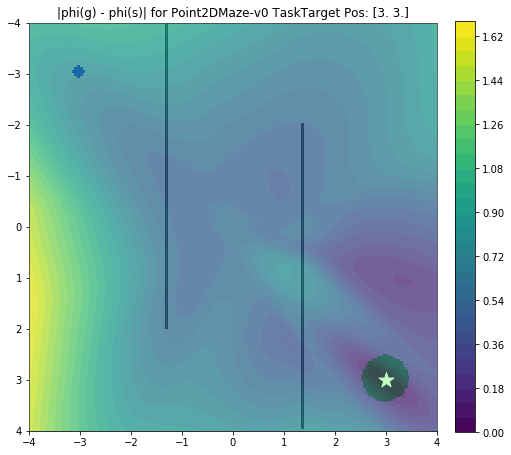

Epoch 960: Loss: 16.532
Epoch 970: Loss: 16.467
Epoch 980: Loss: 15.437
Epoch 990: Loss: 15.794


In [69]:
# Keep results for plotting
train_loss_results = []

if embedding_fns[0] is not embedding_fns[1]:
    var_list = (embedding_fns[0].trainable_variables
                + embedding_fns[1].trainable_variables)
else:
    var_list = embedding_fns[0].trainable_variables
    
def get_ground_truth_data():
    return ground_truth_data(lambda s1, s2: train_env._env.unwrapped._medium_maze_distance({'state_achieved_goal': s1, 'state_desired_goal': s2}), max_path_length, batch_size=batch_size)
    
def get_replay_data():
    return get_data(replay_pool, max_path_length, batch_size=batch_size)


data_sampler_fn = get_ground_truth_data # Change this to switch between training on trajectories vs. ground truth labels
num_epochs = 1000
batch_size = 64
# gt_dataset = iter(gt_dataset.shuffle(n_samples * n_samples, reshuffle_each_iteration=True)
#                         .repeat(num_epochs * 10)
#                         .batch(batch_size))
    
for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()

    for i in range(10):
        s1, s2, distance = data_sampler_fn()

        loss_value, grads = grad(embedding_fns, var_list, s1, s2, distance)
        optimizer.apply_gradients(zip(grads, var_list))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())

    if epoch % 10 == 0:
        print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
    if epoch % 50 == 0:
        clear_output()
        plot_embedding()

In [111]:
n_samples = 50
target_pos = train_env.unwrapped._get_obs()['state_desired_goal']
goal_vals = np.repeat(target_pos[None], n_samples * n_samples, axis=0)
grid_vals, xys = get_grid_vals(train_env, n_samples)
obs = {
    'state_achieved_goal': grid_vals,
    'state_desired_goal': goal_vals
}

features = grid_vals
labels = train_env._env.unwrapped._medium_maze_distance(obs, dist_type="direct")
gt_dataset = tf.data.Dataset.from_tensor_slices((features, labels))

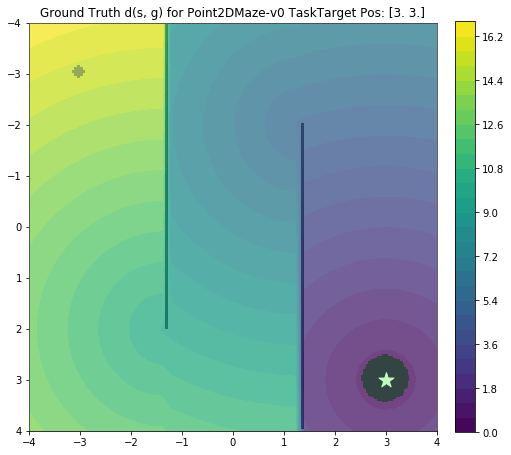

In [112]:
# Plot true distances to learn
plt.figure(figsize=(8, 8))

plt.imshow(train_env.render('rgb_array', width=256, height=256),
           extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)

plt.gca().invert_yaxis()
plt.contourf(xys[0], xys[1], labels.reshape(xys[0].shape), levels=30, zorder=1)
plt.colorbar(fraction=0.046, pad=0.04)
# plot_trajectories(checkpoint, f'{seed_path}/checkpoint_200')

plt.scatter(*target_pos, marker='*', s=250, color='white', zorder=2)

plt.title(f'Ground Truth d(s, g) for {domain + task} Task'
          + f'Target Pos: {target_pos}')
plt.show()

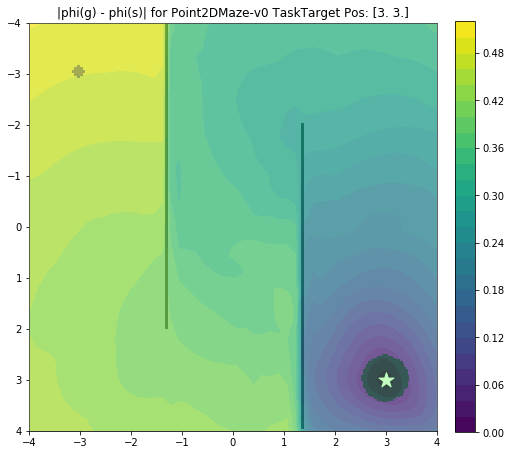

Epoch 160: Loss: 19.212
Epoch 170: Loss: 19.207
Epoch 180: Loss: 19.189
Epoch 190: Loss: 19.689


In [113]:
# Keep results for plotting
train_loss_results = []

if embedding_fns[0] is not embedding_fns[1]:
    var_list = (embedding_fns[0].trainable_variables
                + embedding_fns[1].trainable_variables)
else:
    var_list = embedding_fns[0].trainable_variables
    
num_epochs = 200
batch_size = 64
gt_dataset_iter = iter(gt_dataset.shuffle(n_samples * n_samples, reshuffle_each_iteration=True)
                        .repeat(num_epochs)
                        .batch(batch_size))
    
for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()

    for i in range(n_samples * n_samples // batch_size):
        s1, distance = next(gt_dataset_iter)
        s2 = np.repeat(target_pos[None], batch_size, axis=0)

        loss_value, grads = grad(embedding_fns, var_list, s1, s2, distance)
        optimizer.apply_gradients(zip(grads, var_list))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())

    if epoch % 10 == 0:
        print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
    if epoch % 50 == 0:
        clear_output()
        plot_embedding()

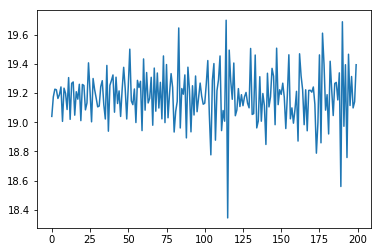

In [114]:
plt.plot(train_loss_results)

In [115]:
with open('./gt_embedding_fn.pkl', 'wb') as f:
    pickle.dump(embedding_fn, f)

In [117]:
%ls

Untitled.ipynb                    gt_embedding_fn.pkl
ddl.ipynb                         pnml.ipynb
embedding_fn_2.pkl                train_embedding.ipynb
embedding_fn_seed0.pkl            vice_reward_visualizations.ipynb
embedding_fn_seed6.pkl


### Train using ground truth distances

In [ ]:
# Keep results for plotting
train_loss_results = []

num_epochs = 1000
batch_size = 64

if embedding_fns[0] is not embedding_fns[1]:
    var_list = (embedding_fns[0].trainable_variables
                + embedding_fns[1].trainable_variables)
else:
    var_list = embedding_fns[0].trainable_variables
    
for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()

    for i in range(10):
        s1, s2, distance = get_data(replay_pool,
                                    max_path_length,
                                    batch_size=batch_size)

        loss_value, grads = grad(embedding_fns, var_list, s1, s2, distance)
        optimizer.apply_gradients(zip(grads, var_list))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())

    if epoch % 10 == 0:
        print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
    if epoch % 50 == 0:
        clear_output()
        plot_embedding()

### Plot distance predictions using the learned embedding

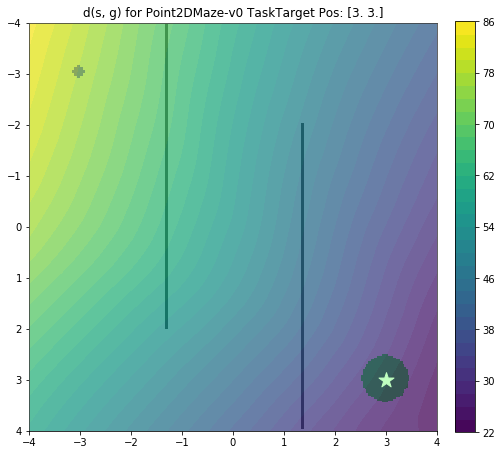

In [96]:
target_pos = train_env.unwrapped._get_obs()['state_desired_goal']

n_samples = 50
obs_space = train_env.observation_space['state_observation']
xs = np.linspace(obs_space.low[0], obs_space.high[0], n_samples)
ys = np.linspace(obs_space.low[1], obs_space.high[1], n_samples)

xys = np.meshgrid(xs, ys)

grid_vals = np.array(xys).transpose(1, 2, 0).reshape((n_samples * n_samples, 2))
goal_vals = np.repeat(target_pos[None], n_samples * n_samples, axis=0)
dists = distance_fn.predict([grid_vals, goal_vals])

plt.figure(figsize=(8, 8))

plt.imshow(train_env.render('rgb_array', width=256, height=256),
           extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)

plt.gca().invert_yaxis()
plt.contourf(xys[0], xys[1], dists.reshape(xys[0].shape), levels=30, zorder=1)
plt.colorbar(fraction=0.046, pad=0.04)

plt.scatter(*target_pos, marker='*', s=250, color='white', zorder=2)

plt.title(f'd(s, g) for {domain + task} Task'
          + f'Target Pos: {target_pos}')
plt.show()

In [38]:
def plot_embedding():
    target_pos = train_env.unwrapped._get_obs()['state_desired_goal']

    n_samples = 50
    obs_space = train_env.observation_space['state_observation']
    xs = np.linspace(obs_space.low[0], obs_space.high[0], n_samples)
    ys = np.linspace(obs_space.low[1], obs_space.high[1], n_samples)

    xys = np.meshgrid(xs, ys)

    grid_vals = np.array(xys).transpose(1, 2, 0).reshape((n_samples * n_samples, 2))
    goal_vals = np.repeat(target_pos[None], n_samples * n_samples, axis=0)
    dists = np.linalg.norm(embedding_fns[1].predict(goal_vals) - embedding_fns[0].predict(grid_vals), axis=-1)

    plt.figure(figsize=(8, 8))

    plt.imshow(train_env.render('rgb_array', width=256, height=256),
               extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)

    plt.gca().invert_yaxis()
    plt.contourf(xys[0], xys[1], dists.reshape(xys[0].shape), levels=30, zorder=1)
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.scatter(*target_pos, marker='*', s=250, color='white', zorder=2)

    plt.title(f'|phi(g) - phi(s)| for {domain + task} Task'
              + f'Target Pos: {target_pos}')
    plt.show()

NameError: name 'target_pos' is not defined

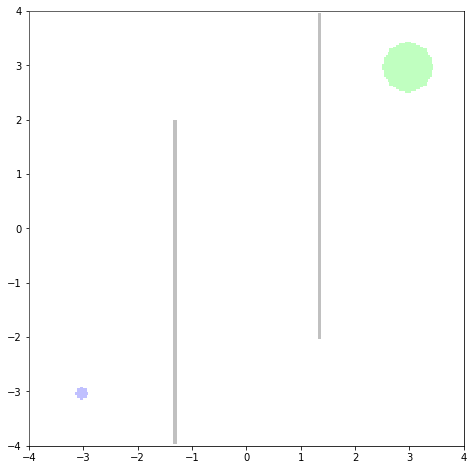

In [29]:
num_traj = 20

trajs = replay_pool.last_n_batch(max_path_length * num_traj)

plt.figure(figsize=(8, 8))

plt.imshow(train_env.render('rgb_array', width=256, height=256),
           extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)
plt.scatter(*target_pos, marker='*', s=250, color='white', zorder=2)

for i in range(num_traj):
    trajectory = trajs['observations']['state_observation'][i*max_path_length:max_path_length*(i+1)]
    plt.plot(trajectory[:, 0], trajectory[:, 1], 'black')

radii = np.arange(0.5, 9, 0.5)
circles = []
for r in radii:
    pts = []
    for theta in np.arange(0, 2 * np.pi + np.pi / 30, np.pi / 30):
        dx = r * np.cos(theta)
        dy = r * np.sin(theta)
        pt = target_pos + np.array([dx, dy])
        x, y = pt
        if -4 <= x and x <= 4 and -4 <= y and y <= 4:
            pts.append(np.array([[x, y]]))
    circles.append(np.vstack(pts))

for circle in circles:
    plt.plot(circle[:, 0], circle[:, 1])
    
plt.gca().invert_yaxis()

plt.title(f'|phi(g) - phi(s)| for {domain + task} Task\n'
          + f'Target Pos: {target_pos}')
plt.show()

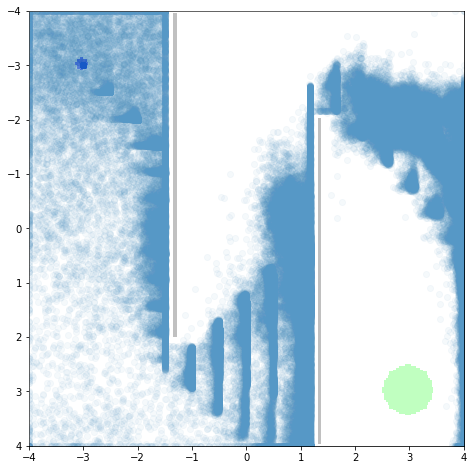

In [30]:
non_zero_rows = replay_pool.data[('observations', 'state_observation')].any(axis=-1)
visitations = replay_pool.data[('observations', 'state_observation')][non_zero_rows]
plt.figure(figsize=(8, 8))
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().invert_yaxis()
plt.imshow(train_env.render('rgb_array'),
           extent=(-4, 4, -4, 4),
           origin='lower',
           alpha=0.25,
           zorder=3,
           interpolation='nearest')

plt.scatter(visitations[:, 0], visitations[:, 1], alpha=0.05)

ValueError: need at least one array to concatenate

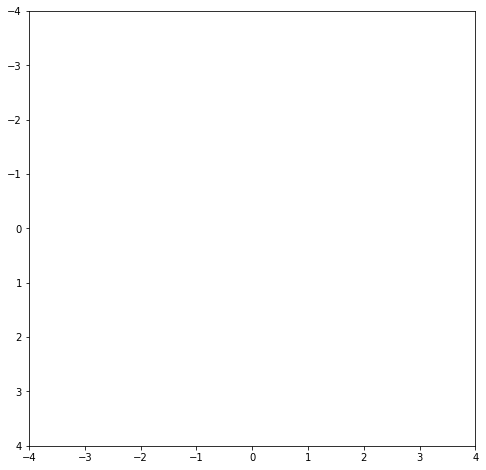

In [31]:
plt.figure(figsize=(8, 8))
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().invert_yaxis()
end_state_idxs = np.arange(99, replay_pool.size, 100)
end_states = replay_pool.data[('observations', 'state_observation')][non_zero_rows][end_state_idxs]

success = np.where(np.linalg.norm(end_states - np.array([3, 3]), axis=-1) < 1)[0]
include_idxs = end_state_idxs[success]
include_idxs.shape

all_idxs_to_include = np.concatenate([
    np.arange(include_idx - 99, include_idx + 1)
    for include_idx in include_idxs
])

success_data = replay_pool.data[('observations', 'state_observation')][non_zero_rows][all_idxs_to_include]

# plt.scatter(end_states[:, 0], end_states[:, 1], alpha=0.05)
plt.scatter(end_states[success][:, 0], end_states[success][:, 1], alpha=0.05)

In [32]:
success_data.shape

NameError: name 'success_data' is not defined

In [33]:
replay_pool.data[('observations', 'state_observation')][non_zero_rows][0]

array([-3., -3.], dtype=float32)

In [34]:
np.arange(99, replay_pool.size, 100)

array([    99,    199,    299, ..., 999799, 999899, 999999])

# Use a Distance Function Instead

In [35]:
from softlearning.models.utils import get_distance_estimator_from_variant

variant['distance_fn_params'] = {
    'type': 'feedforward_distance_fn',
    'kwargs': {
        'hidden_layer_sizes': (256, ) * 2,
        'observation_keys': None,
        'observation_keys': ('state_observation', ),
#         'kernel_regularizer': tf.keras.regularizers.l2(5e-4)
    }
}

distance_fn = get_distance_estimator_from_variant(variant, train_env)

In [36]:
ddl_optimizer = tf.compat.v1.train.AdamOptimizer(
    learning_rate=3e-4,
    name='distance_fn_optimizer')

loss_object = tf.keras.losses.MeanSquaredError()
def loss(model, s1, s2, distance):
    return loss_object(y_true=distance, y_pred=model([s1, s2]))

def grad(model, s1, s2, distance):
    with tf.GradientTape() as tape:
        loss_value = loss(model, s1, s2, distance)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [37]:
# Keep results for plotting
train_loss_results = []

num_epochs = 501
batch_size = 64

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()

    for i in range(10):
        s1, s2, distance = get_data(replay_pool,
                                    max_path_length,
                                    batch_size=batch_size)

        loss_value, grads = grad(distance_fn, s1, s2, distance)
        optimizer.apply_gradients(zip(grads, distance_fn.trainable_variables))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())

    if epoch % 10 == 0:
        print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
    if epoch % 50 == 0:
        clear_output()
        plot_embedding()

InvalidArgumentError: cannot compute ConcatV2 as input #1(zero-based) was expected to be a float tensor but is a uint64 tensor [Op:ConcatV2] name: concat

In [104]:
def plot_embedding():
    target_pos = train_env.unwrapped._get_obs()['state_desired_goal']

    n_samples = 50
    obs_space = train_env.observation_space['state_observation']
    xs = np.linspace(obs_space.low[0], obs_space.high[0], n_samples)
    ys = np.linspace(obs_space.low[1], obs_space.high[1], n_samples)

    xys = np.meshgrid(xs, ys)

    grid_vals = np.array(xys).transpose(1, 2, 0).reshape((n_samples * n_samples, 2))
    goal_vals = np.repeat(target_pos[None], n_samples * n_samples, axis=0)
    dists = distance_fn.predict([grid_vals, goal_vals])

    plt.figure(figsize=(8, 8))

    plt.imshow(train_env.render('rgb_array', width=256, height=256),
               extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)

    plt.gca().invert_yaxis()
    plt.contourf(xys[0], xys[1], dists.reshape(xys[0].shape), levels=30, zorder=1)
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.scatter(*target_pos, marker='*', s=250, color='white', zorder=2)

    plt.title(f'd(s, g) for {domain + task} Task'
              + f'Target Pos: {target_pos}')
    plt.show()